In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from   astropy.io import fits as pyfits
import csv
import sys
import os
from   timeit import default_timer as timer
import warnings
import corner

from alderaan.constants import *

# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

In [11]:
# select mission, target, and paths
MISSION = "Simulated"
TARGET  = "S00837"
PRIMARY_DIR = '/Users/research/projects/alderaan/'

SHAPE_FILE = '/Users/research/projects/alderaan/Traces/' + TARGET + '/' + TARGET + '_transit_shape.fits'
HBM_FILE   = '/Users/research/projects/alderaan/Traces/' + TARGET + '/' + TARGET + '_hbm_ttvs.fits'

# Make sure the necessary paths exist

In [12]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs    
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'

# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Get period and epoch from shape model posteriors

In [13]:
# Read in the fits file with saved traces

with pyfits.open(SHAPE_FILE) as trace:
    header  = trace[0].header
    hdulist = pyfits.HDUList(trace)
    
    NDRAWS, NPL = trace['P'].shape
    
    # planetary parameters
    T0   = trace['T0'].data
    P    = trace['P'].data
    
    
epochs = np.median(T0,0)
periods = np.median(P,0)

# Get HBM TTV model posteriors

In [14]:
with pyfits.open(HBM_FILE) as hbm_trace:
    header = hbm_trace[0].header
    hdulist = pyfits.HDUList(hbm_trace)
    
    NPL = int((len(hdulist)-1)/5)
    NDRAWS = hbm_trace['POP_SD_0'].data.shape[0]
    
    # TTV parameters
    OFFSET = [None]*NPL
    TTS    = [None]*NPL
    POP_SD = [None]*NPL
    
    for npl in range(NPL):
        try: OFFSET[npl] = hbm_trace['OFFSET_{0}'.format(npl)].data
        except: pass

        try: TTS[npl] = hbm_trace['TTS_{0}'.format(npl)].data
        except: pass
        
        try: POP_SD[npl] = hbm_trace['POP_SD_{0}'.format(npl)].data
        except: pass

In [15]:
hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  TTS_0         1 ImageHDU         8   (337, 2000)   float64   
  2  TREND_0       1 ImageHDU         8   (337, 2000)   float64   
  3  OFFSET_0      1 ImageHDU         8   (337, 2000)   float64   
  4  POP_SD_0      1 ImageHDU         8   (13, 2000)   float64   
  5  GROUP_0       1 ImageHDU         7   (337,)   int64   
  6  TTS_1         1 ImageHDU         8   (214, 2000)   float64   
  7  TREND_1       1 ImageHDU         8   (214, 2000)   float64   
  8  OFFSET_1      1 ImageHDU         8   (214, 2000)   float64   
  9  POP_SD_1      1 ImageHDU         8   (9, 2000)   float64   
 10  GROUP_1       1 ImageHDU         7   (214,)   int64   


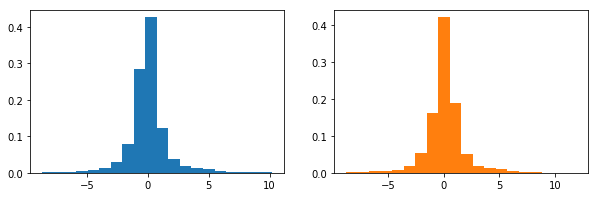

In [16]:
fig, ax = plt.subplots(1, NPL, figsize=(5*NPL,3))

for npl in range(NPL):
    off = OFFSET[npl].reshape(-1)
    
    bins = np.linspace(np.percentile(off,0.3),np.percentile(off,99.7),21)
    
    ax[npl].hist(off, bins=bins, density=True, color="C{0}".format(npl))

plt.show()

# Get transit times, linear ephemeris and O-C

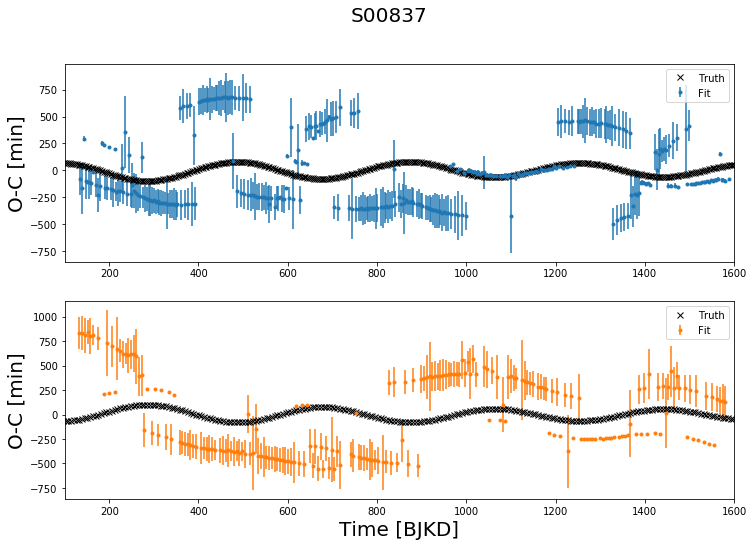

In [17]:
fig, ax = plt.subplots(NPL, figsize=(12,8))

for npl in range(NPL):
    tts = np.nanmedian(TTS[npl], 0)
    tts = tts[~np.isnan(tts)]
    
    inds = np.array(np.floor((tts - epochs[npl] + periods[npl]/2)/periods[npl]), dtype='int')
    
    pfit  = np.polyfit(inds, tts, 1)
    ephem = np.polyval(pfit, inds)
    
    xtime = tts
    yomc  = (tts - ephem)*24*60
    yerr  = np.nanstd(TTS[npl], 0)*24*60
    yerr  = yerr[~np.isnan(yerr)]
    
    # flag outliers
    out = np.abs(yomc - np.median(yomc))/astropy.stats.mad_std(yomc) > 8.0
    out += np.abs(yerr - np.median(yerr))/astropy.stats.mad_std(yerr) > 8.0
    
    
    ax[npl].errorbar(xtime[~out], yomc[~out], yerr=yerr[~out], fmt='.', color='C{0}'.format(npl), label="Fit")
    ax[npl].set_ylabel('O-C [min]', fontsize=20)
    ax[npl].set_xlim(100,1600)    
    
    
    if MISSION == "Simulated":
        true_tts_file = PRIMARY_DIR + 'Simulations/TTVs/' + TARGET + '_{:02d}'.format(npl) + '_sim_ttvs.txt'
        
        inds_true, tts_true = np.loadtxt(true_tts_file).swapaxes(0,1)
        
        pfit_true = np.polyfit(inds_true, tts_true, 1)
        ephem_true = np.polyval(pfit_true, inds_true)
        
        xtime_true = tts_true
        yomc_true  = (tts_true - ephem_true)*24*60
        
        ax[npl].plot(xtime_true, yomc_true, "kx", label="Truth")
        #ax[npl].set_ylim(-20,20)
        ax[npl].legend()

    
ax[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.suptitle(TARGET, fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + "_ttvs_hbm.pdf", bbox_inches="tight")
plt.show()

# Fit Matern-3/2 GP to the HBM TTVs

In [9]:
import pymc3 as pm
import theano.tensor as T
import exoplanet as exo
from scipy import stats
from   sklearn.cluster import KMeans


PLANET 0
106 transits -- performing GP regression with Matern-3/2 kernel

iteration 1


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho_off, log_sigma]
Sampling 2 chains: 100%|██████████| 15000/15000 [00:43<00:00, 345.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]
100%|██████████| 4000/4000 [00:08<00:00, 481.62it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


loc [-0.00410626]
scale [0.43135561 2.91029212]
11 outliers found out of 106 transit times (10.0%)

iteration 2


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho_off, log_sigma]
Sampling 2 chains: 100%|██████████| 15000/15000 [00:37<00:00, 399.46draws/s]
The number of effective samples is smaller than 25% for some parameters.


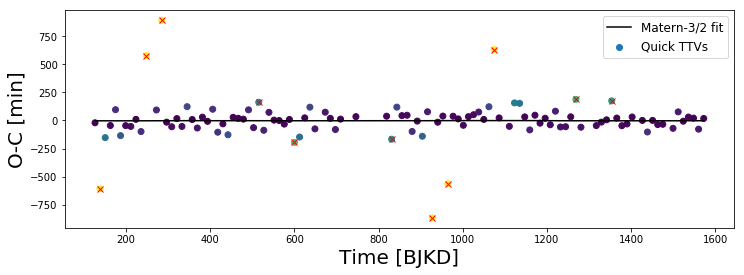


PLANET 1
74 transits -- performing GP regression with Matern-3/2 kernel

iteration 1


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho_off, log_sigma]
Sampling 2 chains: 100%|██████████| 15000/15000 [00:47<00:00, 313.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]
100%|██████████| 4000/4000 [00:07<00:00, 514.32it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


loc [0.10268756]
scale [2.79877226 0.69606743]
8 outliers found out of 74 transit times (11.0%)

iteration 2


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho_off, log_sigma]
Sampling 2 chains: 100%|██████████| 15000/15000 [00:44<00:00, 336.47draws/s]


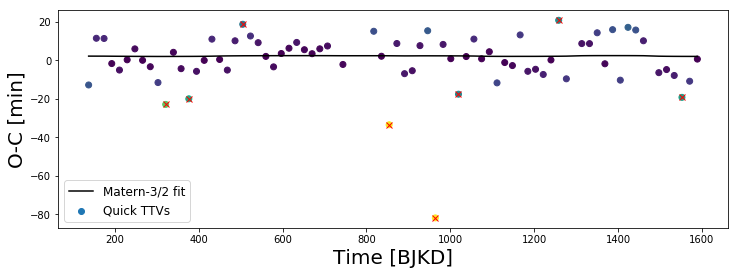

In [10]:
for npl in range(NPL):
    print("\nPLANET", npl)

    tts = np.nanmedian(TTS[npl], 0)
    tts = tts[~np.isnan(tts)]
    
    inds = np.array(np.floor((tts - epochs[npl] + periods[npl]/2)/periods[npl]), dtype='int')
    
    pfit  = np.polyfit(inds, tts, 1)
    ephem = np.polyval(pfit, inds)
    
    xtime = tts
    yomc  = tts - ephem
    yerr  = np.nanstd(TTS[npl], 0)*24*60
    yerr  = yerr[~np.isnan(yerr)]
    
    # flag outliers
    out = np.abs(yomc - np.median(yomc))/astropy.stats.mad_std(yomc) > 8.0
    out += np.abs(yerr - np.median(yerr))/astropy.stats.mad_std(yerr) > 8.0
    
    ntrans = len(xtime)
    
    # for a relatively large number of transits, GPs are appropriate
    if ntrans > 16:
        print("{0} transits -- performing GP regression with Matern-3/2 kernel".format(ntrans))
        
        loop = True
        iteration = 0
        while loop:
            iteration += 1
            print("\niteration", iteration)

            # fit a GP with a Matern-3/2 kernel
            with pm.Model() as matern_model:

                # build the kernel 
                log_sigma = pm.Normal("log_sigma", mu=np.log(np.std(yomc)), sd=10)

                log_rho_off = pm.Normal("log_rho_off", mu=np.log(2*periods[npl]), sd=5)
                rho = pm.Deterministic("rho", 4*periods[npl] + T.exp(log_rho_off))
                log_rho = pm.Deterministic("log_rho", T.log(rho))

                kernel = exo.gp.terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho)

                # nusiance parameters
                mean = pm.Normal("mean", mu=np.mean(yomc), sd=10)
                logvar = pm.Normal("logvar", mu=np.log(np.var(yomc)), sd=10)

                # here's the GP
                gp = exo.gp.GP(kernel, xtime[~out], T.exp(logvar)*T.ones(len(xtime[~out])))

                # add custom potential (log-prob fxn) with the GP likelihood
                pm.Potential("obs", gp.log_likelihood(yomc[~out] - mean))

                # track GP prediction
                gp_pred = pm.Deterministic("gp_pred", gp.predict(xtime))

                trend = pm.Deterministic("trend", mean + gp.predict(xtime))


            with matern_model:
                matern_trace = pm.sample(tune=6000, draws=1500, start=matern_model.test_point, chains=2, 
                                         step=exo.get_dense_nuts_step(target_accept=0.9))

            # stop looping if the maximum number of iterations has been reached
            if iteration >= 2:
                loop = False

            else:
                # fit a mixture model to the residuals
                res = yomc - np.nanmedian(matern_trace["trend"], 0)
                resnorm = res / np.std(res)
                resnorm -= np.mean(resnorm)

                with pm.Model() as mix_model:
                    w = pm.Dirichlet("w", np.array([1.,1.]))
                    mu = pm.Normal("mu", mu=0.0, sd=5.0, shape=1)
                    tau = pm.Gamma("tau", 1.0, 1.0, shape=2)
                    obs = pm.NormalMixture("obs", w, mu=mu*T.ones(2), tau=tau, observed=resnorm)

                with mix_model:
                    mix_trace = pm.sample(tune=3000, draws=1000, start=mix_model.test_point, chains=1, 
                                          step=exo.get_dense_nuts_step(target_accept=0.9))


                # calculate foreground/background probabilities
                loc = np.nanmedian(mix_trace["mu"], axis=0)
                scale = np.nanmedian(1/np.sqrt(mix_trace["tau"]), axis=0)

                print("loc", loc)
                print("scale", scale)


                order = np.argsort(scale)
                scale = scale[order]

                z_fg = stats.norm(loc=loc, scale=scale[0]).pdf(resnorm)
                z_bg = stats.norm(loc=loc, scale=scale[1]).pdf(resnorm)

                fg_prob = z_fg/(z_fg+z_bg)


                # use KMeans clustering to assign each point to the foreground or background
                km = KMeans(n_clusters=2)
                group = km.fit_predict(fg_prob.reshape(-1,1))
                centroids = np.array([np.mean(fg_prob[group==0]), np.mean(fg_prob[group==1])])

                bad = group == np.argmin(centroids)
                print("{0} outliers found out of {1} transit times ({2}%)".format(np.sum(bad), len(bad), 
                                                                                  np.round(100*np.sum(bad)/len(bad))))

                # check for convergence and update outlier flagss
                if np.alltrue(bad == out):
                    loop = False

                out = np.copy(bad)


        # save the final results
        trend  = np.nanmedian(matern_trace["trend"],0)


        # plot the final trend and outliers
        plt.figure(figsize=(12,4))
        plt.scatter(xtime, yomc*24*60, c=1-fg_prob, cmap="viridis", label="Quick TTVs")
        plt.plot(xtime[bad], yomc[bad]*24*60, "rx")
        plt.plot(xtime, trend*24*60, "k", label="Matern-3/2 fit")
        plt.xlabel("Time [BJKD]", fontsize=20)
        plt.ylabel("O-C [min]", fontsize=20)
        plt.legend(fontsize=12)
        plt.show()
        
        
        
    # for a relatively small number of transits, fit a polynomial trend
    elif (ntrans <= 16)*(ntrans > 1):
        print("{0} transits -- fitting a polynomial model".format(ntrans))
        
        biclist = []
        for i in range(1, int(np.ceil(np.sqrt(ntrans)))):
            poly_coeffs = np.polyfit(xtime, yomc, i)
            poly_trend = np.polyval(poly_coeffs, xtime)

            RSS = np.sum((yomc-poly_trend)**2)
            BIC = ntrans*np.log(RSS/ntrans) + (i+1)*np.log(ntrans)

            biclist.append(BIC)

        polyorder = np.argmin(biclist)+1
        
        print("lowest BIC at polyorder = {0}".format(polyorder))    

        
        trend = np.polyval(np.polyfit(xtime, yomc, polyorder), xtime)
    
        # plot the final trend and outliers
        plt.figure(figsize=(12,4))
        plt.scatter(xtime, yomc*24*60, c=np.ones_like(trend), cmap="viridis", label="Quick TTVs")
        plt.plot(xtime, trend*24*60, "k", label="Polynomial fit")
        plt.xlabel("Time [BJKD]", fontsize=20)
        plt.ylabel("O-C [min]", fontsize=20)
        plt.legend(fontsize=12)
        plt.show()
    
    

    # store the results
    #ftts   = indep_ephemeris[npl] + trend
    #fephem = np.polyval(np.polyfit(transit_inds[npl], ftts, 1), transit_inds[npl])
    
    #fixed_transit_times.append(ftts)
    #fixed_ephemeris.append(fephem)